In [47]:
import sys
!{sys.executable} -m pip install s3fs

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [1]:
from __future__ import print_function
%matplotlib inline

import sys
from urllib.request import urlretrieve
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

In [2]:
# This is base class used for prediction. It can be at top and not dependent on anyone except imports
from sagemaker.serializers import IdentitySerializer
class DeepARPredictor(sagemaker.predictor.Predictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, 
                         #serializer=JSONSerializer(),
                         serializer=IdentitySerializer(content_type="application/json"),
                         **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)
        
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.date_range(start=prediction_time, freq=freq, periods=prediction_length)
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

As I have already loaded csv file to s3, I will use it to create timeseries list which will be required to pass for prediction.
This is step not required to do now, but will be eventually needed.

In [3]:
csv_path = 's3://sagemaker-us-east-1-686433372380/sagemaker/electricity/electric.csv'

In [4]:
# It worked well and csv is loaded as table in pandas

import pandas as pd
df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_091,MT_092,MT_093,MT_094,MT_095,MT_096,MT_097,MT_098,MT_099,MT_100
2014-01-01 00:15:00,2.538071,23.470839,0.0,150.406504,73.170732,288.690476,6.218202,235.690236,47.202797,67.741935,...,67.378252,32.710280,1.015228,7.074280,3.143007,6.376812,157.563025,252.059308,402.34375,10.652463
2014-01-01 00:30:00,2.538071,23.470839,0.0,148.373984,78.048780,267.857143,6.783493,252.525253,52.447552,67.741935,...,66.044029,33.229491,1.015228,10.106114,3.143007,6.956522,170.168067,245.469522,394.53125,11.318242
2014-01-01 00:45:00,2.538071,24.182077,0.0,144.308943,74.390244,255.952381,6.218202,249.158249,50.699301,63.440860,...,70.713809,33.229491,1.522843,7.579586,3.143007,5.797101,174.369748,200.988468,257.81250,10.652463
2014-01-01 01:00:00,2.538071,23.470839,0.0,136.178862,74.390244,252.976190,6.218202,249.158249,52.447552,72.043011,...,72.715143,33.229491,1.522843,6.568974,3.143007,5.797101,172.268908,191.103789,253.90625,9.986684
2014-01-01 01:15:00,3.807107,22.759602,0.0,152.439024,70.731707,250.000000,6.783493,252.525253,52.447552,69.892473,...,74.716478,33.229491,1.015228,8.590197,3.143007,6.956522,165.966387,210.873147,261.71875,10.652463


In [5]:
# Now all steps to create timeseries list of lists to pass for predition at end of the process.
data_kw = df.resample('2H').sum() / 8
data_kw.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_091,MT_092,MT_093,MT_094,MT_095,MT_096,MT_097,MT_098,MT_099,MT_100
2014-01-01 00:00:00,2.379442,20.536984,0.0,128.302846,63.719512,218.377976,5.370266,217.171717,44.798951,59.543011,...,61.957972,29.075805,1.078680,7.263770,2.750131,5.797101,145.220588,190.691928,265.136719,9.404128
2014-01-01 02:00:00,2.855330,23.204125,0.0,134.654472,64.786585,196.056548,5.723573,229.797980,49.825175,59.543011,...,72.548366,32.450675,1.522843,8.653360,3.470403,6.956522,163.077731,184.925865,252.441406,10.236352
2014-01-01 04:00:00,2.538071,21.870555,0.0,108.231707,60.213415,149.925595,4.663652,183.080808,41.083916,52.016129,...,75.633756,32.320872,1.205584,8.716523,3.273965,7.028986,163.340336,183.690280,187.011719,10.985353
2014-01-01 06:00:00,3.013959,21.781650,0.0,93.495935,58.384146,142.485119,4.592990,154.882155,37.587413,49.865591,...,71.214143,44.911734,1.522843,7.769075,20.560503,7.246377,155.462185,177.924217,256.835938,10.069907
2014-01-01 08:00:00,0.793147,24.004267,0.0,80.792683,46.951220,135.416667,4.098361,119.107744,55.069930,38.306452,...,67.878586,51.336968,1.269036,6.442648,15.976951,6.666667,170.430672,207.166392,332.031250,10.486019


In [6]:
timeseries = []
num_timeseries = df.shape[1]
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:,i], trim='f'))

In [9]:
(timeseries[0][:10])

2014-01-01 00:00:00    2.379442
2014-01-01 02:00:00    2.855330
2014-01-01 04:00:00    2.538071
2014-01-01 06:00:00    3.013959
2014-01-01 08:00:00    0.793147
2014-01-01 10:00:00    0.475888
2014-01-01 12:00:00    0.475888
2014-01-01 14:00:00    0.475888
2014-01-01 16:00:00    2.220812
2014-01-01 18:00:00    2.855330
Freq: 2H, Name: MT_001, dtype: float64

In [10]:
print(len(timeseries))
print(len(timeseries[0]))

100
4381


In [13]:
# Timeseries is now ready whenever I need it.
# Now I will use train.json and test.json which are stored in s3
sagemaker_session = sagemaker.Session()
s3_bucket = 'sagemaker-us-east-1-686433372380'
s3_prefix = '/sagemaker/electricity'
s3_data_path = 's3://{}{}'.format(s3_bucket, s3_prefix)
s3_output_path = 's3://{}{}/output'.format(s3_bucket, s3_prefix)

In [15]:
s3_data_path

's3://sagemaker-us-east-1-686433372380/sagemaker/electricity'

In [22]:
freq = '2H'
prediction_length = 3 * 12
context_length = 3 * 12

region = sagemaker_session.boto_region_name
#image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")
image_name = sagemaker.image_uris.retrieve(region = region, framework = 'forecasting-deepar' ) 
role = sagemaker.get_execution_role()             # IAM role to use by SageMaker


In [24]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    instance_count=1,
    instance_type='ml.c4.2xlarge',
    base_job_name='deepar-electricity-demo',
    output_path=s3_output_path
)

In [25]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}

In [26]:
estimator.set_hyperparameters(**hyperparameters)

In [28]:
%%time
data_channels = {
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/test/".format(s3_data_path)
}
estimator.fit(inputs=data_channels, wait=True)

2021-02-06 17:45:35 Starting - Starting the training job...
2021-02-06 17:45:38 Starting - Launching requested ML instancesProfilerReport-1612633535: InProgress
.........
2021-02-06 17:47:25 Starting - Preparing the instances for training...
2021-02-06 17:48:06 Downloading - Downloading input data...
2021-02-06 17:48:26 Training - Downloading the training image.......Arguments: train
[02/06/2021 17:49:44 INFO 139692952823616] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_s

In [29]:
%%time
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    predictor_cls=DeepARPredictor)

-------------!CPU times: user 271 ms, sys: 10.4 ms, total: 281 ms
Wall time: 6min 32s


In [36]:
# The previous step creates endpoint. 
# Now I will use it to predict future values in timeseries.
# I will use one list from timeseries object created at start of this notebook.
response = predictor.predict(ts=timeseries[10], quantiles=[0.20, 0.5, 0.80])

In [37]:
len(response)

36

In [38]:
response

,0.8,0.2,0.5
2015-01-01 02:00:00,33.574574,29.195810,31.209879
2015-01-01 04:00:00,32.143036,28.162317,29.888121
2015-01-01 06:00:00,35.214035,29.529940,32.091263
2015-01-01 08:00:00,34.765564,29.588226,32.021854
2015-01-01 10:00:00,49.048203,42.026443,45.086349
2015-01-01 12:00:00,43.697144,35.908176,40.080215
2015-01-01 14:00:00,41.989399,36.100761,38.465931
2015-01-01 16:00:00,48.982998,40.888206,44.579288
2015-01-01 18:00:00,77.754776,67.165169,73.125053
2015-01-01 20:00:00,80.828178,70.326302,75.470016


In [43]:
ts10 = timeseries[10][-30:]

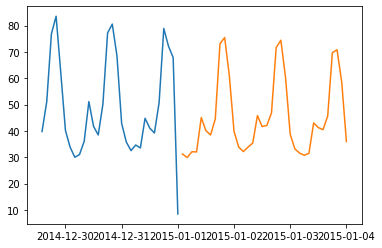

In [46]:
from matplotlib import pyplot as plt
predict10 = response['0.5']
plt.plot(ts10)
plt.plot(predict10)

plt.show()

In [45]:
predict10 = response['0.5']

2015-01-01 02:00:00    31.209879
2015-01-01 04:00:00    29.888121
2015-01-01 06:00:00    32.091263
2015-01-01 08:00:00    32.021854
2015-01-01 10:00:00    45.086349
2015-01-01 12:00:00    40.080215
2015-01-01 14:00:00    38.465931
2015-01-01 16:00:00    44.579288
2015-01-01 18:00:00    73.125053
2015-01-01 20:00:00    75.470016
2015-01-01 22:00:00    60.907204
2015-01-02 00:00:00    39.842648
2015-01-02 02:00:00    33.844673
2015-01-02 04:00:00    32.139492
2015-01-02 06:00:00    33.879761
2015-01-02 08:00:00    35.397987
2015-01-02 10:00:00    45.837109
2015-01-02 12:00:00    41.659092
2015-01-02 14:00:00    42.067135
2015-01-02 16:00:00    46.812256
2015-01-02 18:00:00    71.626236
2015-01-02 20:00:00    74.442200
2015-01-02 22:00:00    60.279926
2015-01-03 00:00:00    38.727486
2015-01-03 02:00:00    33.144390
2015-01-03 04:00:00    31.579119
2015-01-03 06:00:00    30.741528
2015-01-03 08:00:00    31.486128
2015-01-03 10:00:00    43.029530
2015-01-03 12:00:00    41.266277
2015-01-03

In [48]:
csv_write_path = 's3://sagemaker-us-east-1-686433372380/sagemaker/electricity/response10.csv'
#df.to_csv('s3://experimental/playground/temp_csv/dummy.csv', index=False)
response.to_csv(csv_write_path, index = True)

In [ ]:
# ******Remember to delete endpoint at end of the session before you close this book and leave.*******